## Part two WiDS Datathon Maastricht 

### Let's start by introducing the machine learning pipeline and loading the data 

Populating the interactive namespace from numpy and matplotlib


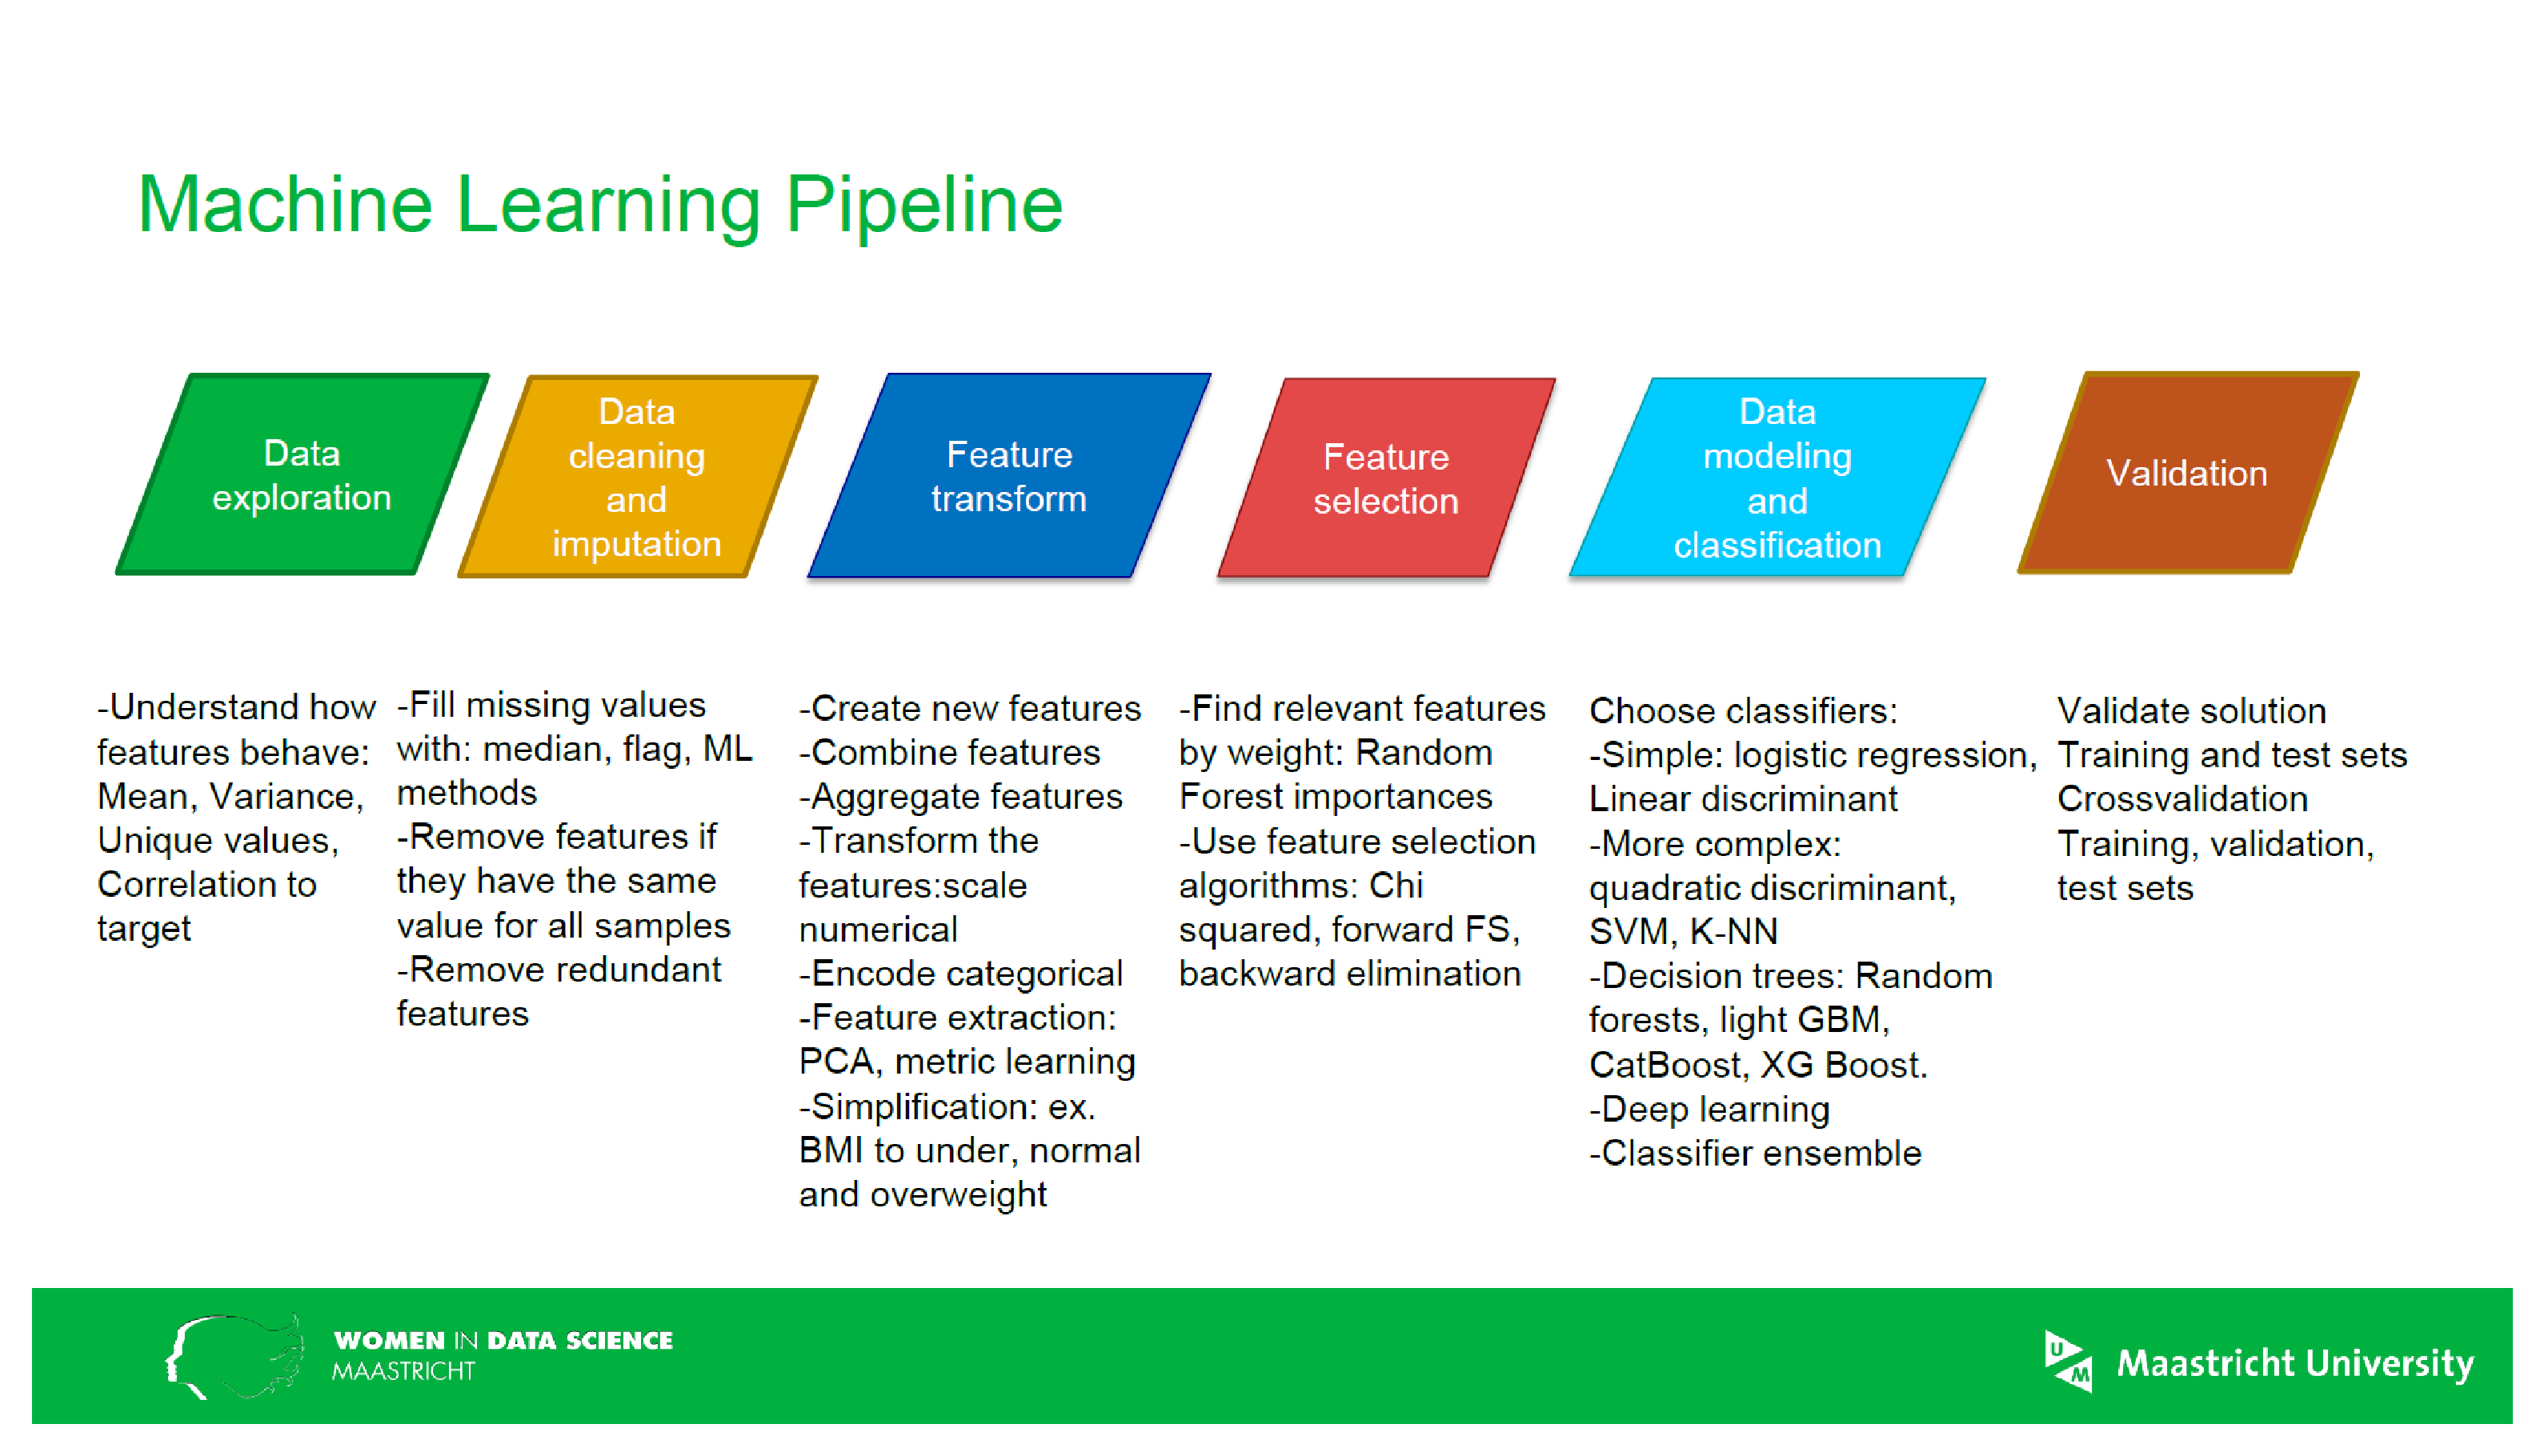

In [1]:

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
#import plotly.express as px
sns.set_style("whitegrid", {'axes.grid': False})

%pylab inline
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
figure(num=None, figsize=(10, 10), dpi=400)
matplotlib.pyplot.axis('off') 
img = mpimg.imread('slide.png')
imgplot = plt.imshow(img)
plt.show()

### Some data exploration 

(130157, 181)
(10234, 180)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


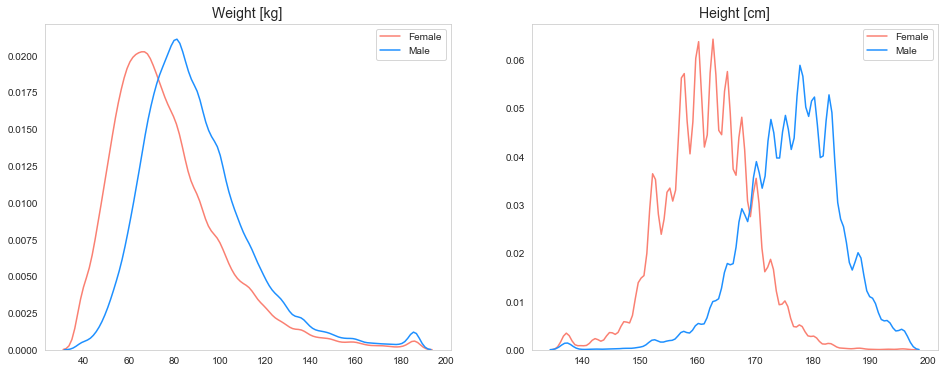

In [2]:
class_target = "diabetes_mellitus"
train_ = pd.read_csv("TrainingWiDS2021.csv")
print(train_.shape)
predict_ = pd.read_csv("UnlabeledWiDS2021.csv")
print(predict_.shape)
data_dictionary  = pd.read_csv("DataDictionaryWiDS2021.csv")
train_['label'] = 'train'
predict_['label'] = 'test'

train_.drop(['encounter_id', 'hospital_id', 'Unnamed: 0'], inplace=True, axis=1)
predict_.drop(['encounter_id', 'hospital_id', 'Unnamed: 0'], inplace=True, axis=1)



train_["height"] = np.where((train_.height.isna() & (train_.gender == 'F')),
                              160, train_["height"])
train_["height"] = np.where((train_.height.isna() & (train_.gender == 'M')),
                              180, train_["height"])
train_["height"] = np.where((train_.height.isna() & (train_.gender.isna())),
                              170, train_["height"])
train_["weight"] = np.where((train_.height.isna() & (train_.gender == 'F')),
                              65, train_["weight"])
train_["weight"] = np.where((train_.height.isna() & (train_.gender == 'M')),
                              82, train_["weight"])
train_["weight"] = np.where((train_.height.isna() & (train_.gender.isna())),
                              74, train_["weight"])

predict_["height"] = np.where((predict_.height.isna() & (predict_.gender == 'F')),
                             160, predict_["height"])
predict_["height"] = np.where((predict_.height.isna() & (predict_.gender == 'M')),
                             180, predict_["height"])
predict_["height"] = np.where((predict_.height.isna() & (predict_.gender.isna())),
                              170, predict_["height"])
predict_["weight"] = np.where((predict_.height.isna() & (predict_.gender == 'F')),
                             65, predict_["weight"])
predict_["weight"] = np.where((predict_.height.isna() & (predict_.gender == 'M')),
                             82, predict_["weight"])
predict_["weight"] = np.where((predict_.height.isna() & (predict_.gender.isna())),
                              74, predict_["weight"])

# some data exploration for the weight and height 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.kdeplot(train_[train_.gender == 'F'].weight, label='Female', color='salmon', ax=ax[0])
sns.kdeplot(train_[train_.gender == 'M'].weight, label='Male', color='dodgerblue', ax=ax[0])
ax[0].set_title('Weight [kg]', fontsize=14)

sns.kdeplot(train_[train_.gender == 'F'].height, label='Female', color='salmon', ax=ax[1])
sns.kdeplot(train_[train_.gender == 'M'].height, label='Male', color='dodgerblue', ax=ax[1])
ax[1].set_title('Height [cm]', fontsize=14)

plt.show()


### Discarding columns and samples with too many missing values and imputing missing values for the remaining ones

In [4]:


# drop columns with > 80% missing values
lst = train_.isna().sum() / len(train_)
p = pd.DataFrame(lst)
p.reset_index(inplace=True)
p.columns = ['a', 'b']
low_count = p[p['b'] > 0.8]
todelete = low_count['a'].values
print(todelete)
train_.drop(todelete, axis=1, inplace=True)
predict_.drop(todelete, axis=1, inplace=True)


# drop rows with > 50% missing values

def get_row_miss_percent(tr):
#    """
#    Adds a feature into the dataframe indicating the missing
#    value percentage of the corresponding row
#    """
    ncols = train_.shape[1]
    f = (train_.isnull().sum(axis=1) / ncols) * 100

    return f

f = get_row_miss_percent(train_)

train_ = train_.loc[f[:] < 50]

train_test_feats = [train_, predict_]
train_test = pd.concat(train_test_feats, keys=['Tr', 'Te'],sort=True)


## impute 
categorical_cols = ['icu_id', 'ethnicity', 'gender', 'hospital_admit_source',
                    'icu_admit_source', 'icu_stay_type', 'icu_type',
                    'aids', 'cirrhosis', 'hepatic_failure','ethnicity',
                    'apache_2_diagnosis', 'apache_3j_diagnosis']


binary_cols = ['elective_surgery','apache_post_operative','arf_apache',
               'intubated_apache','ventilated_apache','aids','cirrhosis',
               'gcs_eyes_apache','gcs_verbal_apache', 'gcs_motor_apache' ,
               'gcs_unable_apache','diabetes_mellitus','hepatic_failure','readmission_status',
               'immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']


for i, v in enumerate(binary_cols):
    train_test[v] = train_test[v].fillna(10)

# filling categorical columns with median value
for i, v in enumerate(categorical_cols):
    train_test[v] = train_test[v].fillna(train_test[v].value_counts().index[0])


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
#from sklearn.impute import KNNImputer
#knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
#imputed = train_test.copy(deep=True)
#imputer = IterativeImputer()

# if you want to use an imputer with more options
#cat_imputer = SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = "missing")
#train_test[categorical_cols] = cat_imputer.fit_transform(train_test[categorical_cols])


features = train_test.columns
numeric_cols = [col for col in features if col not in categorical_cols and col not in binary_cols]

for i, v in tqdm(enumerate([numeric_cols])):
    train_test[v] =train_test.groupby(['ethnicity','gender'], sort=False)[v].apply(lambda x: x.fillna(x.mean()))
    
print("The missing values in the train dataset are:", train_test.isnull().sum().sum()) 

[]


1it [00:08,  8.58s/it]

The missing values in the train dataset are: 0


### Creating new features that may provide useful information

['Healthy weight', 'Overweight', 'Obese', 'Underweight']


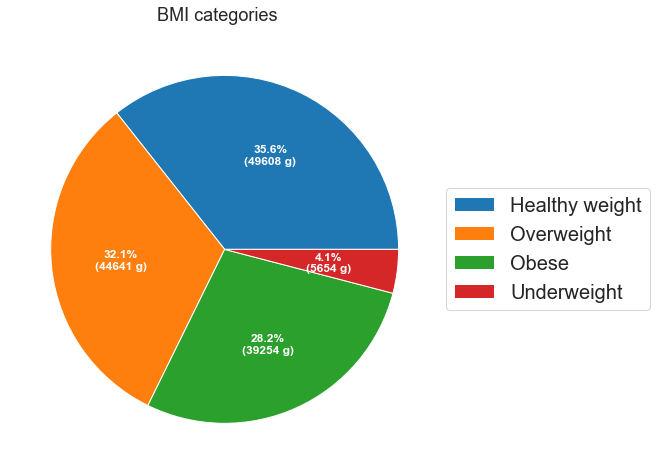

In [16]:

  


def get_bmi_category(bmi):
    if bmi != bmi:  # NaN
        return np.nan
    elif bmi < 18.5:  # Underweight
        return 'Underweight'
    elif bmi < 25:  # Healthy weight
        return 'Healthy weight'
    elif bmi < 30:  # Overweight
        return 'Overweight'
    else:  # Obese
        return 'Obese'    
    

train_test["bmi_cat"] = train_test["bmi"].apply(get_bmi_category)


train_test["bmi_cat"] = train_test["bmi_cat"].fillna(train_test["bmi_cat"].value_counts().index[0])


def get_blood_pressure_category(sysbp, diasbp):
    if ((sysbp < 90) & (diasbp < 60)):
        return 1  # Low blood pressure
    elif ((sysbp < 120) & (diasbp < 80)):
        return 2  # Normal
    elif ((sysbp < 140) & (diasbp < 90)):
        return 3  # Pre-Hypertension
    elif ((sysbp < 160) & (diasbp < 100)):
        return 4  # Stage 1 Hypertension
    else:
        return 5  # Stage 2 Hypertension


train_test['bp_cat'] = train_test[['d1_sysbp_max', 'd1_diasbp_max']].apply(
    lambda x: get_blood_pressure_category(x.d1_sysbp_max, x.d1_diasbp_max), axis=1)

train_test["bp_cat"] = train_test["bp_cat"].fillna(train_test["bp_cat"].value_counts().index[0])

cat_variable = "bmi_cat"

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
labs = list(train_test[cat_variable].dropna().unique()) 
data = train_test[cat_variable].value_counts()

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
print(labs)
ax.legend(wedges, labs,
          loc="right",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 20})

plt.setp(autotexts, size=12, weight="bold")
plt.figtext(.5,.9,'BMI categories', fontsize=18, ha='center')

plt.show()


### Encode categorical features so they are manageable by classifiers

In [17]:
categorical_cols = ['icu_id', 'ethnicity', 'gender', 'hospital_admit_source',
                    'icu_admit_source', 'icu_stay_type', 'icu_type',
                    'aids', 'cirrhosis', 'hepatic_failure','ethnicity',
                    'apache_2_diagnosis', 'apache_3j_diagnosis','bmi_cat','bp_cat' ]
    
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
for i, v in enumerate(categorical_cols):
    train_test[v] = OrdinalEncoder(dtype="str").fit_transform(train_test[[v]].astype(str))
    


### Separate train and test and remove correlations

In [18]:

# separate train and test
train = train_test[train_test['label'] == "train"]
predict = train_test[train_test['label'] == 'test']

print("The total of missing values in the train dataset are:", train.isnull().sum().sum())

train.reset_index(inplace=True)
train.drop(['level_0', 'level_1', 'label'], inplace=True, axis=1)

predict.reset_index(inplace=True)
predict.drop(['level_0', 'level_1', 'label', 'diabetes_mellitus'], inplace=True, axis=1)

features = train.columns

num_feature = [col for col in features if col not in categorical_cols and train[col].dtype != 'object']
drop_columns = []
corr_matrix = train[num_feature].corr().abs()
# Create correlation matrix

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.98
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

train.drop(to_drop, inplace=True, axis=1)

predict.drop(to_drop, inplace=True, axis=1)

train[class_target].value_counts() / len(train)



The total of missing values in the train dataset are: 0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.0    0.782959
1.0    0.217041
Name: diabetes_mellitus, dtype: float64

###  Dealing with class imbalance with either upsampling by exact copy of minority class or SMOTE technique

In [19]:
train[class_target].value_counts() / len(train)

#from imblearn.over_sampling import SMOTENC

#import collections

#def balancingClasses_Smote(x_train, y_train,random_state):

#    catcols = []
    # Using SMOTE to to balance our training data points
#    for i in categorical_cols:
#        catcols.append(x_train.columns.get_loc(i))

#    sm = SMOTENC(categorical_features=catcols, random_state=0)

#    features_balanced, target_balanced = sm.fit_resample(x_train, y_train)

#    print("Count for each class value after SMOTE:", collections.Counter(target_balanced))

#    return features_balanced, target_balanced
#y = train.loc[:,'diabetes_mellitus']

#train, ytrain = balancingClasses_Smote(train,y.values , 0)



#credit 
## upsampling minority class

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

tr_majority = train[train['diabetes_mellitus'] == 0]
tr_minority = train[train['diabetes_mellitus'] == 1]

tr_minority_upsampled = resample(tr_minority,
                                 replace=True,  # sample with replacement
                                 n_samples=84798,  # to match majority class 84798
                                 random_state=1)  # reproducible results

# Combine majority class with upsampled minority class
tr_upsampled = pd.concat([tr_majority, tr_minority_upsampled])

# Display new class counts
tr_upsampled.diabetes_mellitus.value_counts()

train[class_target].value_counts() / len(train)

train = tr_upsampled
train.head(10)


age aids  albumin_apache apache_2_diagnosis apache_3j_diagnosis  \
2   25.0    0        2.842792                 20                 369   
3   81.0    0        2.842792                 24                  71   
6   70.0    0        2.932497                 11                 324   
7   45.0    0        2.700000                 14                  23   
8   50.0    0        3.600000                 10                  28   
9   72.0    0        2.642927                 38                 116   
10  80.0    0        2.842792                 34                 165   
11  48.0    0        2.932497                 36                 304   
12  65.0    0        2.500000                 39                 132   
13  81.0    0        2.932497                 38                 113   

    apache_post_operative  arf_apache  bilirubin_apache        bmi  \
2                       0           0          1.012039  31.952749   
3                       1           0          1.012039  22.635548   
6                       0           0          1.295918  28.916023   
7                       0           0          0.200000  28.916023   
8                       0           0          0.400000  25.707702   
9                       1           0          1.023965  28.257052   
10                      1           0          1.012039  27.382812   
11                      0           0          1.295918  28.916023   
12                      1           0          0.400000  28.916023   
13                      1           0          1.295918  38.189067   

    bun_apache  ... resprate_apache  sodium_apache  \
2    24.041046  ...            37.0     138.004720   
3    24.041046  ...             4.0     138.004720   
6    48.000000  ...            28.0     140.000000   
7    15.000000  ...            14.0     142.000000   
8    10.000000  ...            46.0     139.000000   
9    23.831423  ...            15.0     138.523321   
10   29.000000  ...            24.0     135.000000   
11   26.841166  ...            28.0     137.822495   
12   26.000000  ...            42.0     140.000000   
13   26.000000  ...            31.0     139.000000   

    solid_tumor_with_metastasis  temp_apache  urineoutput_apache  \
2                             0         36.7          1682.03238   
3                             0         34.8          1682.03238   
6                             0         36.6          1881.01001   
7                             0         36.9          1881.01001   
8                             0         36.3          1881.01001   
9                             0         36.8          1688.81630   
10                            0         36.4          1682.03238   
11                            0         36.6          1881.01001   
12                            0         36.6          1881.01001   
13                            0         37.1          1881.01001   

    ventilated_apache  wbc_apache      weight  bmi_cat  bp_cat  
2                   0   12.336955   95.300000        1       2  
3                   1    8.000000   61.700000        0       2  
6                   1   12.800000   90.284347        2       2  
7                   1   24.700000   90.284347        2       0  
8                   0    8.400000   79.000000        2       1  
9                   0   12.018577   67.800000        2       2  
10                  0   12.336955   70.100000        2       1  
11                  0   12.248140   90.284347        2       3  
12                  0   10.300000   90.284347        2       1  
13                  0    6.900000  113.900000        1       0  

[10 rows x 138 columns]

### Scaling the numerical features, beneficial for distance based classifiers to avoid larger scales being dominant  in the decisions instead of discriminative features

In [20]:

import pandas as pd
from sklearn import preprocessing
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()


#### If you want to inspect outliers or use some type of flag features if the sample is an outlier
#from sklearn.neighbors import LocalOutlierFactor
#from sklearn.ensemble import IsolationForest
#iso = LocalOutlierFactor(n_neighbors=35, contamination=0.1)
#iso = IsolationForest(contamination=0.05)
#trainonlynondiabetes = train[train["diabetes_mellitus"]==0]
#outliers = iso.fit_predict(trainonlynondiabetes.values)
# select all rows that are not outliers
#train = train[mask, :]
#train = train.loc[outliers!=-1]


## scaling numerical columns 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newtr = train.select_dtypes(include=numerics)
numeric_cols = newtr.columns
num = np.delete(numeric_cols, np.where(numeric_cols == 'diabetes_mellitus'))

train[num] = min_max_scaler.fit_transform(train[num])
predict[num] = min_max_scaler.fit_transform(predict[num])



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Visualize the data by MDS and save your data so you do not have to do the preprocessing again when testing the classifiers

(185741, 138)
[0. 1.]


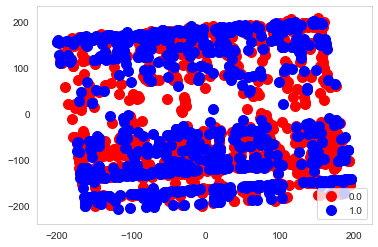

In [25]:
from sklearn.manifold import MDS

y_train = train[class_target]
chosen_idx = np.random.choice(180000, size=2000)
train_mds = train.values
print(train_mds.shape)
train_mds = train_mds[chosen_idx, :]
y_train = y_train.iloc[chosen_idx]
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(train_mds)
cdict = {0: 'red', 1: 'blue'}
fig, ax = plt.subplots()
print(np.unique(y_train))
for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(X_transformed[ix,0], X_transformed[ix,1], c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

train.to_pickle("traindat.csv")
predict.to_pickle("predictdat.csv")

## Classification

### Loading the data and selecting features by Random Forest

(148592, 137) (37149, 137)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


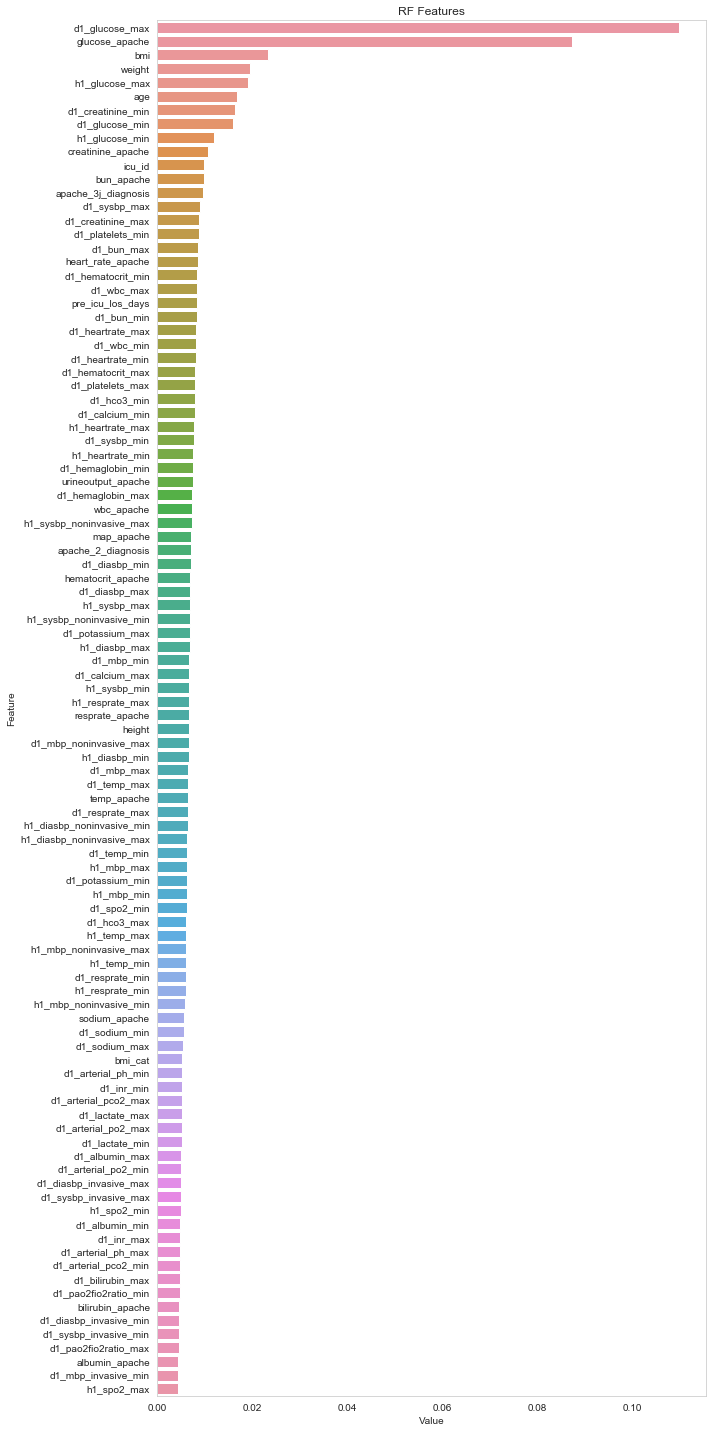

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from math import exp
from scipy.spatial.distance import pdist, squareform
sns.set_style("whitegrid", {'axes.grid': False})
import os
from sklearn.model_selection import train_test_split
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.neighbors import KNeighborsClassifier
#from metric_learn import LMNN, LFDA
#from metric_learn import SCML_Supervised
#from metric_learn import NCA
#from metric_learn import lfda
from sklearn.metrics import accuracy_score

train = pd.read_pickle("traindat.csv")
predict = pd.read_pickle("predictdat.csv")

X_train, X_test, y_train, y_test = train_test_split(
    train[[c for c in train if class_target != c]], train[class_target], test_size=0.20, random_state=1)
print(X_train.shape, X_test.shape)


totrf = 50

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
data = X_train.values

clf.fit(data, y_train)

fet_indrf1 = np.argsort(clf.feature_importances_)[::-1]
fet_imp = clf.feature_importances_[fet_indrf1]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])
data=feature_imp.sort_values(by="Value", ascending=False)
data = data.iloc[0:100, :]
plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=data)
plt.title('RF Features')
plt.tight_layout()
#plt.show()



### Feature selection by LASSO and combination of 3 feature selectors

[  0   1   2   3   4   5   6   7   8   9  10  11  12  21  22  23  24  25
  26  27  29  30  31  32  33  34  35  36  37  38  39  40  41  48  50  52
  53  54  55  64  65  68  69  74  76  77  78  79  80  81  83  84  85  86
  97 102 103 104 105 108 110 111 112 113 114 115 116 117 118 121 125 127
 130 131 132 133 134 135 136]


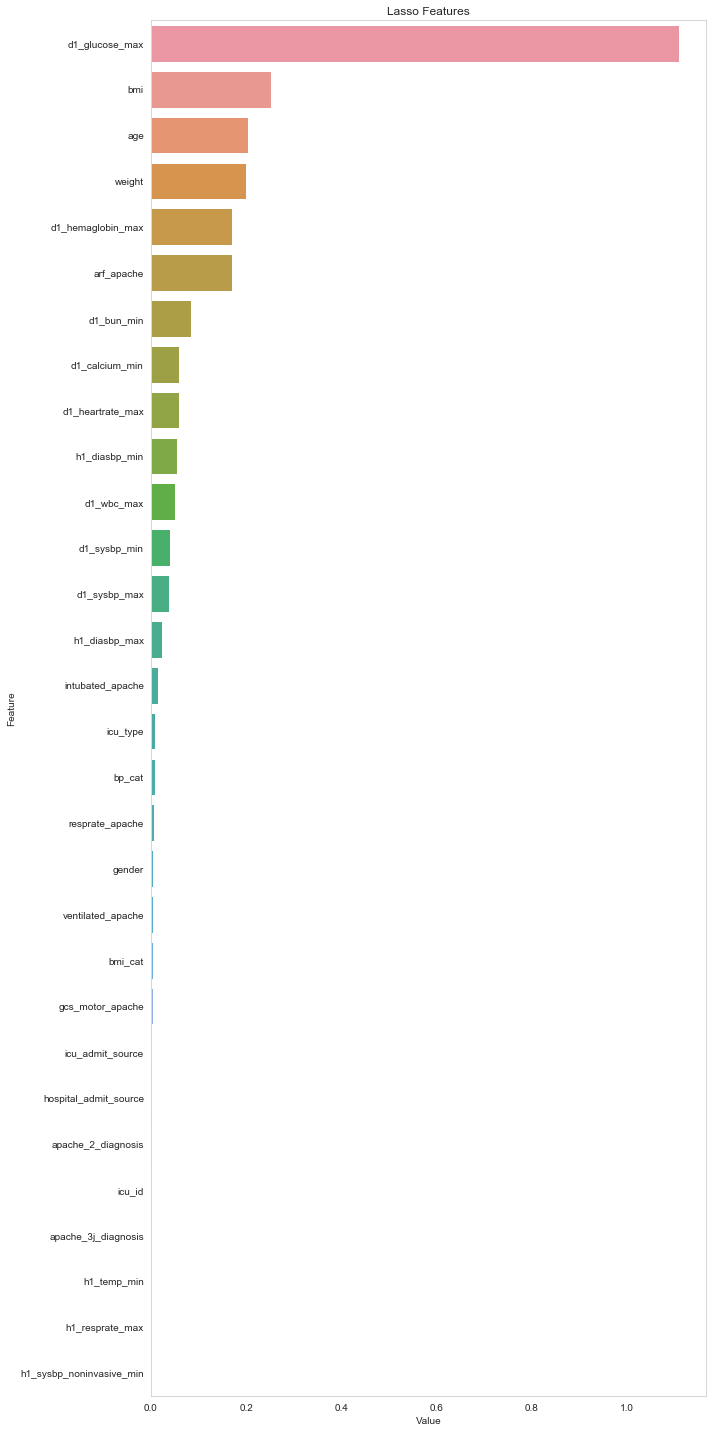

In [27]:

from sklearn.linear_model import LassoCV
lasso = LassoCV().fit(X_train.values, y_train)
importance = np.abs(lasso.coef_)
feature_names = np.array(X_train.columns)

fet_indrf2 = np.argsort(importance)[::-1]
totlasso = 30
feature_imp = pd.DataFrame(columns=['Value','Feature'])
feature_imp.loc[:,'Value'] = importance
feature_imp.loc[:,'Feature'] = X_train.columns

feature_imp = pd.DataFrame(sorted(zip(importance, X_train.columns)), columns=['Value','Feature'])
data=feature_imp.sort_values(by="Value", ascending=False)
data = data.iloc[0:30, :]
plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=data)
plt.title('Lasso Features')
plt.tight_layout()
#plt.show()


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
mn = np.min(X_train)
select_k_best_classifier = SelectKBest(chi2, k=40)
X_train_chi = select_k_best_classifier.fit(X_train, y_train)

mask = select_k_best_classifier.get_support() #list of booleans
chi_f = [] # The list of your K best features
feature_names = X_train.columns
a_list = list(range(1, len(X_train.columns)))
for bool, feature in zip(mask, a_list):
    if bool:
        chi_f.append(feature)

all_feat_2 = np.concatenate((fet_indrf1[0:totrf],fet_indrf2[0:totlasso]), axis=0)
all_feat_3 = np.concatenate((all_feat_2,chi_f), axis=0)
fet_ind = np.unique(all_feat_3,return_index=False)
X_train = pd.DataFrame(X_train)
print(fet_ind)
X_train = X_train.iloc[:, fet_ind]
X_test = pd.DataFrame(X_test)
X_test = X_test.iloc[:, fet_ind]
predict = pd.DataFrame(predict)
predict = predict.iloc[:, fet_ind]


### Decision tree classifier

accuracy score decision tree is 0.7264529327841934


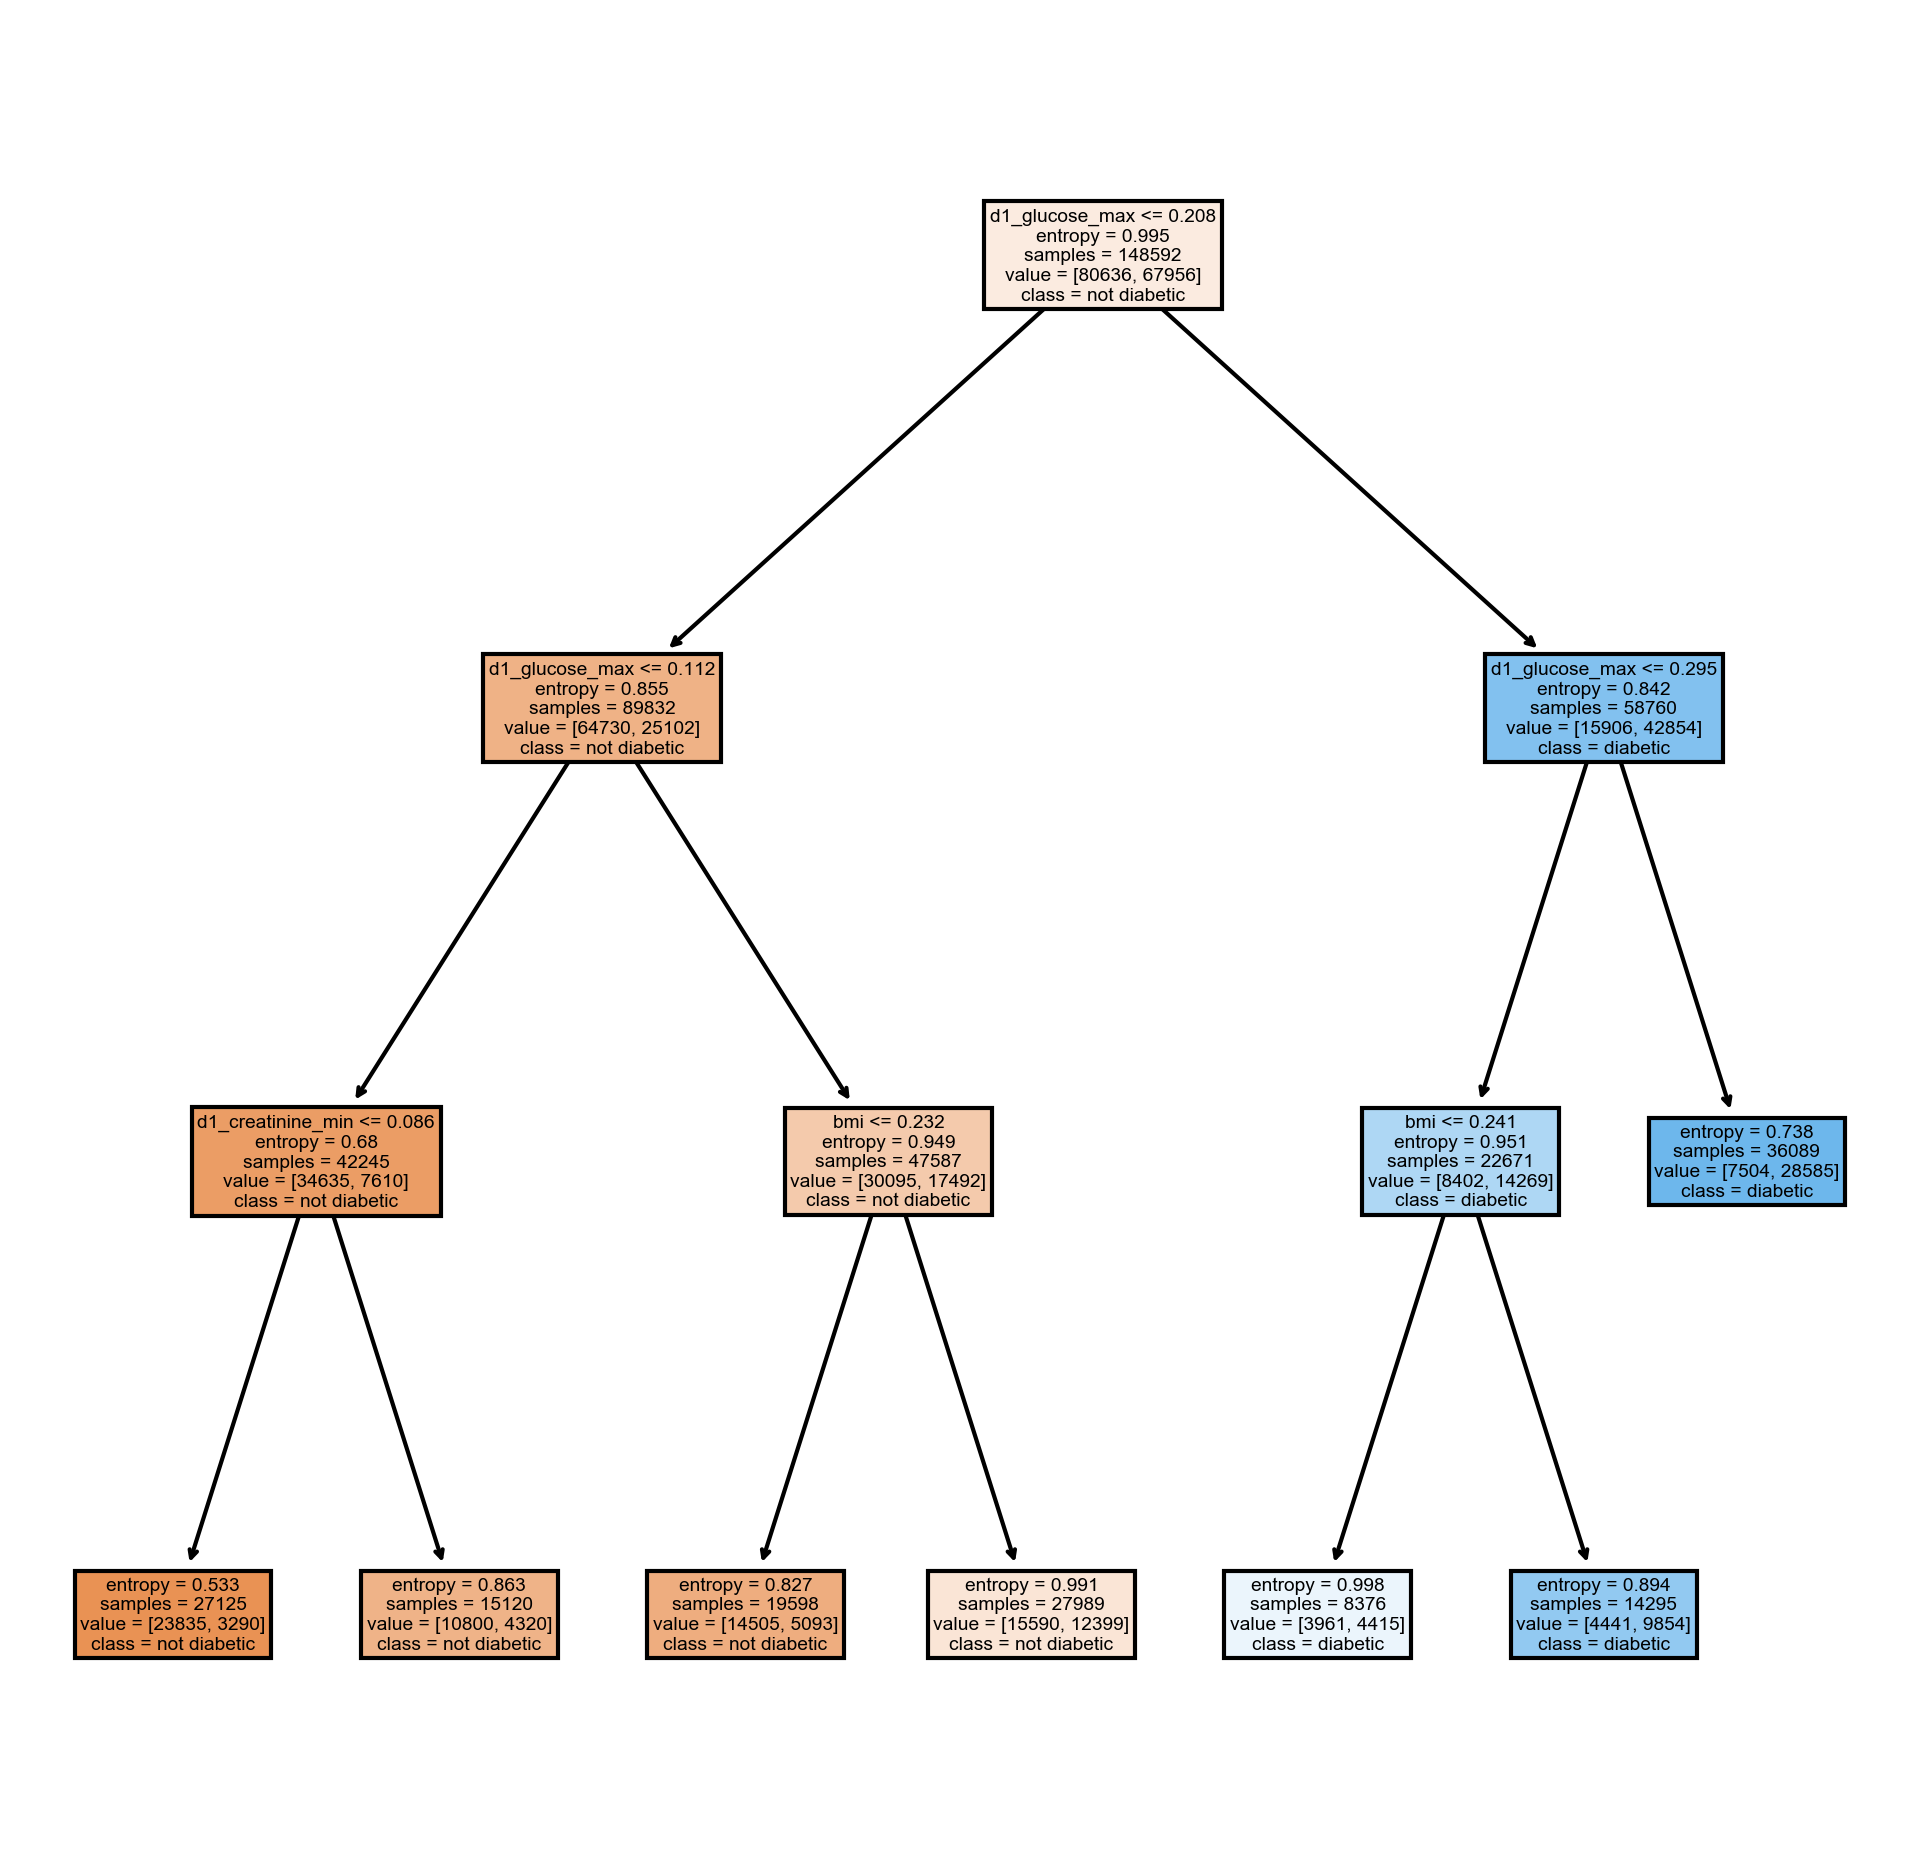

In [29]:
# Decision Tree Classifier and visualization
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', random_state=0, max_leaf_nodes = 7, min_samples_leaf = 5, max_depth= 3)
dt.fit(X_train.values, y_train)
print(f"accuracy score decision tree is {accuracy_score(y_test, dt.predict(X_test.values))}")
fn = X_train.columns
cn = ['not diabetic', 'diabetic']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300)
from sklearn import tree
for style in plt.style.available:
    with plt.style.context(style):
        tree.plot_tree(dt,
                   feature_names=fn,
                   class_names=cn,
                   filled=True);

fig.savefig('tree.png')
plt.show()


### Classifiers and classifier ensemble

In [31]:



# two different SVM methods you can use
#from sklearn import svm
#from libsvm.svmutil import *
#clf1 = svm_train(y_train.values, X_train.values, '-c 4')
#p_label, p_acc, p_val = svm_predict(y_test.values, X_test.values, clf1)
#clf1 = svm.SVC()
#clf1 = svm.NuSVC(gamma='auto')
#clf1.fit(X_train, y_train)
#print(f"accuracy score is {accuracy_score(y_test, clf1.predict(X_test))}")

#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#clf = LinearDiscriminantAnalysis()
#clf.fit(X_train,y_train)


#from sklearn.ensemble import BaggingClassifier
#from sklearn.neighbors import KNeighborsClassifier
# model = BaggingClassifier(KNeighborsClassifier(n_neighbors=1),
#                            max_samples=0.7, max_features=0.7)

#from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import BernoulliNB
#from sklearn.naive_bayes import CategoricalNB
#gnb = CategoricalNB()
#gnb.fit(X_train, y_train)
#print(f"accuracy score LGBM is {accuracy_score(y_test, gnb.predict(X_test))}")

#X_trainnn = X_train[X_train.columns[X_train.columns.isin(numeric_cols)]]
#X_testnn = X_test[X_test.columns[X_test.columns.isin(numeric_cols)]]
#predictnn = predict[predict.columns[predict.columns.isin(numeric_cols)]]

#from sklearn.decomposition import PCA
#pca = PCA(n_components=40)
#X_trainnn =pca.fit_transform(X_trainnn)
#X_testnn =pca.transform(X_testnn)
#predictnn =pca.transform(predictnn)
#print(pca.explained_variance_ratio_)
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#clf1 = LinearDiscriminantAnalysis()

# XGBClassifier Classifier

from xgboost import XGBClassifier

clf4 = XGBClassifier(max_depth=30, n_estimators=50,  objective='multi:softprob', learning_rate=0.3, num_class=2)
clf4.fit(X_train.values, y_train)
from sklearn.metrics import precision_score, recall_score, accuracy_score
pred = clf4.predict(X_test.values)
print(f"accuracy xgb is {accuracy_score(y_test, clf4.predict(X_test.values))}")


#Random forest classifier
clf1 = RandomForestClassifier(n_estimators=50, random_state=1, max_depth=40)
clf1.fit(X_train.values, y_train)
print(f"accuracy score RF is {accuracy_score(y_test, clf1.predict(X_test.values))}")

# LightGBM classifier
from lightgbm import LGBMClassifier
f = X_train
clf2 = LGBMClassifier()
clf2.fit(f.values, y_train)

print(f"accuracy score LGBM is {accuracy_score(y_test, clf2.predict(X_test.values))}")


# Catboost classifier
from catboost import CatBoostClassifier
clf3 = CatBoostClassifier(iterations=50,
                           learning_rate=1,
                           depth=5)
clf3.fit(X_train.values, y_train)
print(f"accuracy score cat is {accuracy_score(y_test, clf3.predict(X_test.values))}")
# print(classification_report(y_test, clf5.predict(X_test), labels=[0, 1]))

import shap
shap.initjs()
explainer = shap.TreeExplainer(clf3)
shap_values = explainer.shap_values(X_train.values)


# 1-NN classifier
clf5 = KNeighborsClassifier(n_neighbors=1)
clf5.fit(X_train, y_train)
print(f"accuracy score NN is {accuracy_score(y_test, clf3.predict(X_test))}")
print(classification_report(y_test, clf3.predict(X_test), labels=[0, 1]))


#ensemble of 5 classifiers
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(
    estimators=[('rf', clf1), ('lgbm', clf2), ('catboost', clf3),('xgboost', clf4),('NN', clf5)],
    voting='soft', weights=[4,1,1,4,1])

model.fit(X_train.values, y_train)
print(f"accuracy score voting is {accuracy_score(y_test, model.predict(X_test.values))}")
print(classification_report(y_test, model.predict(X_test.values), labels=[0, 1]))
pred = model.predict_proba(predict.values)[:, 1]

test = pd.read_csv("UnlabeledWiDS2021.csv")
print(test.shape)
test['label'] = 'test'
test[class_target] = pred
test[["encounter_id", "diabetes_mellitus"]].to_csv("./submissin_voting.csv", index=False)



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:11:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy xgb is 0.933591752133301
accuracy score RF is 0.9342377991332202
accuracy score LGBM is 0.7984871732751891
0:	learn: 0.5526363	total: 48.6ms	remaining: 2.38s
1:	learn: 0.5328396	total: 97.7ms	remaining: 2.34s
2:	learn: 0.5250142	total: 140ms	remaining: 2.2s
3:	learn: 0.5160820	total: 191ms	remaining: 2.19s
4:	learn: 0.5071086	total: 241ms	remaining: 2.17s
5:	learn: 0.5035401	total: 289ms	remaining: 2.12s
6:	learn: 0.5005219	total: 334ms	remaining: 2.05s
7:	learn: 0.4972753	total: 384ms	remaining: 2.02s
8:	learn: 0.4942889	total: 438ms	remaining: 1.99s
9:	learn: 0.4908598	total: 486ms	remaining: 1.94s
10:	learn: 0.4888245	total: 533ms	remaining: 1.89s
11:	learn: 0.4867882	

accuracy score NN is 0.7854316401518211
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     20307
           1       0.76      0.77      0.76     16842

    accuracy                           0.79     37149
   macro avg       0.78      0.78      0.78     37149
weighted avg       0.79      0.79      0.79     37149

0:	learn: 0.5526363	total: 65.9ms	remaining: 3.23s
1:	learn: 0.5328396	total: 123ms	remaining: 2.95s
2:	learn: 0.5250142	total: 177ms	remaining: 2.78s
3:	learn: 0.5160820	total: 240ms	remaining: 2.75s
4:	learn: 0.5071086	total: 302ms	remaining: 2.72s
5:	learn: 0.5035401	total: 358ms	remaining: 2.63s
6:	learn: 0.5005219	total: 416ms	remaining: 2.56s
7:	learn: 0.4972753	total: 471ms	remaining: 2.47s
8:	learn: 0.4942889	total: 534ms	remaining: 2.43s
9:	learn: 0.4908598	total: 594ms	remaining: 2.38s
10:	learn: 0.4888245	total: 649ms	remaining: 2.3s
11:	learn: 0.4867882	total: 700ms	remaining: 2.22s
12:	learn: 0.4848555	total: 759

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:16:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy score voting is 0.9339955315082505
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     20307
           1       0.90      0.96      0.93     16842

    accuracy                           0.93     37149
   macro avg       0.93      0.94      0.93     37149
weighted avg       0.94      0.93      0.93     37149

(10234, 180)
